In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv("SeoulBikeDataClean.csv")
df = df[df['functioning_day'] == 'Yes'].copy()
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.head())


(8465, 33)
Index(['date', 'rented_bike_count', 'hour', 'temperaturec', 'humiditypct',
       'wind_speed_m_s', 'visibility_10m', 'dew_point_temperaturec',
       'solar_radiation_mj_m2', 'rainfallmm', 'snowfall_cm', 'seasons',
       'holiday', 'functioning_day', 'datetime', 'weekday', 'month', 'Autumn',
       'Spring', 'Summer', 'Winter', 'time_bin', '0-6_low', '7-9_peak',
       '10-17_rising', '18-19_high', '20-24_decline', 'is_raining',
       'is_snowing', 'temperaturec_squared', 'is_weekend', 'is_holiday',
       'is_working_day'],
      dtype='object')
date                       object
rented_bike_count           int64
hour                        int64
temperaturec              float64
humiditypct                 int64
wind_speed_m_s            float64
visibility_10m              int64
dew_point_temperaturec    float64
solar_radiation_mj_m2     float64
rainfallmm                float64
snowfall_cm               float64
seasons                    object
holiday                  

In [3]:
# Define formula using patsy-style string
formula = (
    'rented_bike_count ~ temperaturec + temperaturec_squared + '
    'is_raining + is_snowing + is_holiday + is_working_day + '
    'C(hour)'
)

# Fit OLS regression model
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      rented_bike_count   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     521.7
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        15:06:30   Log-Likelihood:                -62390.
No. Observations:                8465   AIC:                         1.248e+05
Df Residuals:                    8435   BIC:                         1.251e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              235.0066 

In [4]:
# VIF analysis
X = model.model.exog  # Design matrix
vif_df = pd.DataFrame({
    "Variable": model.model.exog_names,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

print("\nVariance Inflation Factors (VIF):")
print(vif_df.sort_values(by="VIF", ascending=False))


Variance Inflation Factors (VIF):
                Variable        VIF
0              Intercept  27.862566
24          temperaturec   5.297524
25  temperaturec_squared   4.864635
16         C(hour)[T.16]   1.931994
15         C(hour)[T.15]   1.931786
14         C(hour)[T.14]   1.931072
17         C(hour)[T.17]   1.928973
13         C(hour)[T.13]   1.928944
12         C(hour)[T.12]   1.925964
18         C(hour)[T.18]   1.925687
11         C(hour)[T.11]   1.923573
19         C(hour)[T.19]   1.922652
10         C(hour)[T.10]   1.921066
20         C(hour)[T.20]   1.920946
9           C(hour)[T.9]   1.920626
7           C(hour)[T.7]   1.920279
22         C(hour)[T.22]   1.920243
8           C(hour)[T.8]   1.920100
21         C(hour)[T.21]   1.920046
23         C(hour)[T.23]   1.919641
6           C(hour)[T.6]   1.918870
3           C(hour)[T.3]   1.918526
5           C(hour)[T.5]   1.917505
4           C(hour)[T.4]   1.917380
1           C(hour)[T.1]   1.917138
2           C(hour)[T.2]   1.

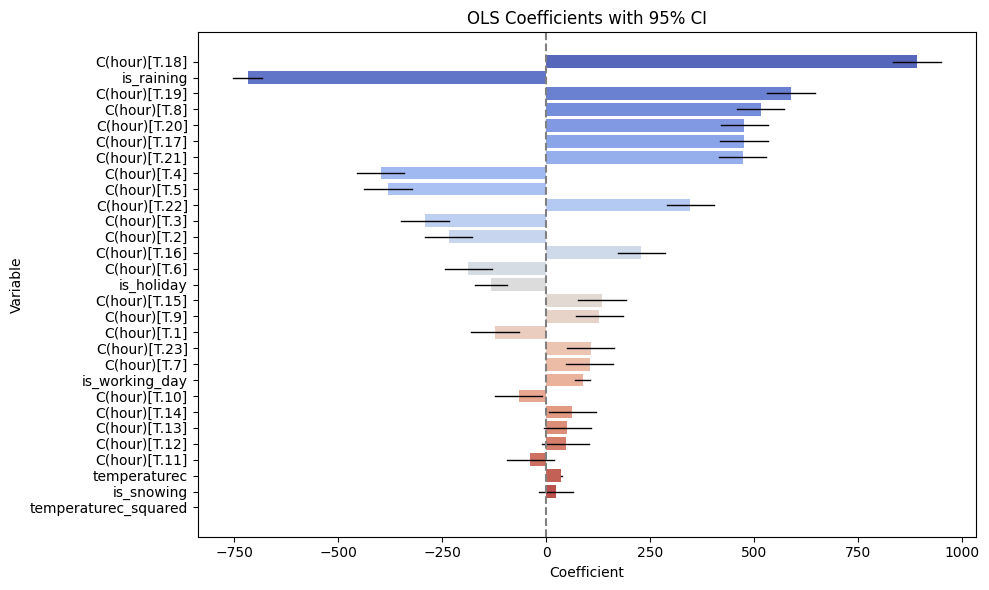

In [5]:
coef_df = model.summary2().tables[1].reset_index()
coef_df.columns = ['variable', 'coef', 'std_err', 't', 'P>|t|', '[0.025', '0.975]']

# Drop intercept
coef_df = coef_df[coef_df['variable'] != 'Intercept']

# Sort by absolute value
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df,
    y='variable', x='coef',
    orient='h',
    palette='coolwarm',
    errorbar=None
)

# 95% CI lines
for i, row in enumerate(coef_df.itertuples()):
    plt.plot([row._6, row._7], [i, i], color='black', lw=1)

plt.axvline(0, color='grey', linestyle='--')
plt.title("OLS Coefficients with 95% CI")
plt.xlabel("Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

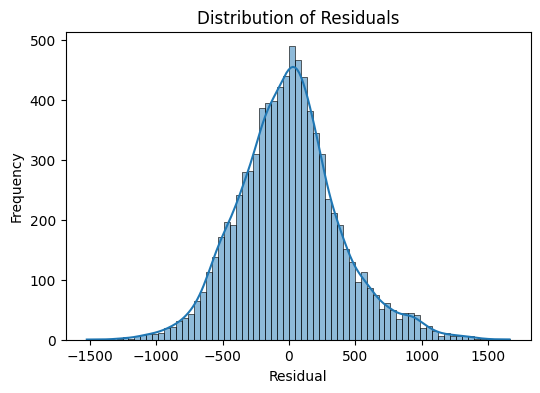

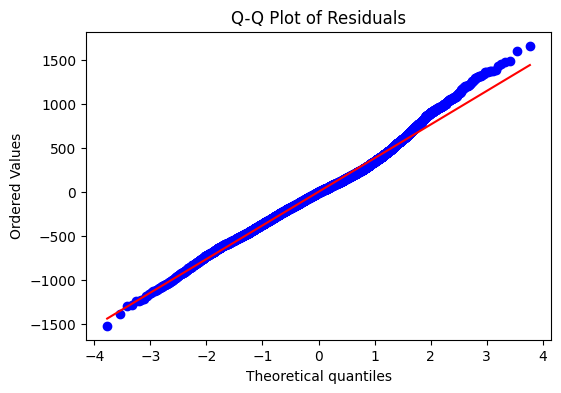

In [6]:
residuals = model.resid

# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


OLS RSS尾部偏离正态